In [ ]:
!pip install langchain==0.1.0

In [ ]:
!pip install openai==1.6.1

In [ ]:
!pip install transformers

In [ ]:
pip install langchainhub

In [1]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

In [2]:
len(docs[0].page_content)

43131

In [3]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=400, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

In [5]:
len(all_splits)

68

In [6]:
len(all_splits[0].page_content)

969

In [8]:
all_splits[2].page_content

'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'

In [8]:
all_splits[10].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 7056}

In [9]:
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings(openai_api_key="sk-proj-dCIgUlQCtRS5KlY8UslJT3BlbkFJ4XJHRYzVWRQClmsczs8h"))

C:\Users\razee\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [78]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

In [11]:
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

In [13]:
embedding = OpenAIEmbeddings(openai_api_key="sk-proj-dCIgUlQCtRS5KlY8UslJT3BlbkFJ4XJHRYzVWRQClmsczs8h")

In [14]:
vectorstore = FAISS.from_documents(documents=all_splits, embedding=embedding)

# Set up the retriever with the desired search type and parameters
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

In [68]:
??vectorstore.as_retriever

In [15]:
retrieved_docs = retriever.invoke("Types of Memory")

In [16]:
len(retrieved_docs)

6

In [18]:
print(retrieved_docs[0].page_content)

Sensory Memory: This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. Subcategories include iconic memory (visual), echoic memory (auditory), and haptic memory (touch).


Short-Term Memory (STM) or Working Memory: It stores information that we are currently aware of and needed to carry out complex cognitive tasks such as learning and reasoning. Short-term memory is believed to have the capacity of about 7 items (Miller 1956) and lasts for 20-30 seconds.


Long-Term Memory (LTM): Long-term memory can store information for a remarkably long time, ranging from a few days to decades, with an essentially unlimited storage capacity. There are two subtypes of LTM:


In [19]:
from langchain_community.chat_models import ChatOpenAI

llm = ChatOpenAI(openai_api_key="sk-proj-dCIgUlQCtRS5KlY8UslJT3BlbkFJ4XJHRYzVWRQClmsczs8h", model_name="gpt-3.5-turbo", temperature=0)

C:\Users\razee\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [20]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [21]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [23]:
for chunk in rag_chain.stream("What is MIPS"):
    print(chunk, end="", flush=True)

MIPS stands for Maximum Inner Product Search, which is a method used to support fast retrieval of embedding representations in a vector store database. It is commonly used with approximate nearest neighbors (ANN) algorithms to trade off accuracy for speed. MIPS algorithms are compared based on recall@10 in performance evaluations.

In [74]:
for chunk in rag_chain.stream("How Hugging GPT Works"):
    print(chunk, end="", flush=True)

HuggingGPT works through a system comprising four stages, with the first stage being task planning. In this stage, the LLM (Large Language Model) acts as the brain, parsing user requests into multiple tasks with attributes like task type, ID, dependencies, and arguments. Few-shot examples are used to guide the LLM in task parsing and planning.

In [82]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("Types of Memory")

'There are three main types of memory: Sensory Memory, Short-Term Memory (STM) or Working Memory, and Long-Term Memory (LTM). Sensory Memory retains impressions of sensory information for a few seconds. Long-Term Memory is divided into Explicit/Declarative Memory (facts and events) and Implicit/Procedural Memory (skills and routines). Thanks for asking!'

In [ ]:
import numpy as np

In [24]:
index = vectorstore.index

In [25]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x000002489CB9A880> >

In [26]:
num_vectors = index.ntotal

In [27]:
num_vectors

68

In [29]:
retrieved_vectors = []
for i in range(num_vectors):
    vector = index.reconstruct(i)
    retrieved_vectors.append(vector)

In [30]:
retrieved_vectors = np.array(retrieved_vectors)
print(f"Retrieved {retrieved_vectors.shape[0]} vectors with dimension {retrieved_vectors.shape[1]}")

Retrieved 68 vectors with dimension 1536


In [23]:
retrieved_vectors

array([[ 0.00398858,  0.00882311, -0.0054288 , ..., -0.01173152,
        -0.00839664, -0.02251222],
       [-0.01945358,  0.0064618 ,  0.03607159, ..., -0.00236694,
        -0.02237093, -0.03010056],
       [-0.00513967,  0.00379128,  0.01969406, ..., -0.0041584 ,
        -0.01627677, -0.02614438],
       ...,
       [-0.01566633,  0.00523379,  0.01055165, ..., -0.01186886,
        -0.01580646, -0.04091744],
       [-0.01764639,  0.01913684,  0.00959654, ..., -0.02539393,
        -0.03020275, -0.02952783],
       [-0.02230632, -0.00363442,  0.01835059, ..., -0.0125955 ,
        -0.01717958, -0.02789004]], dtype=float32)

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [33]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(retrieved_vectors)

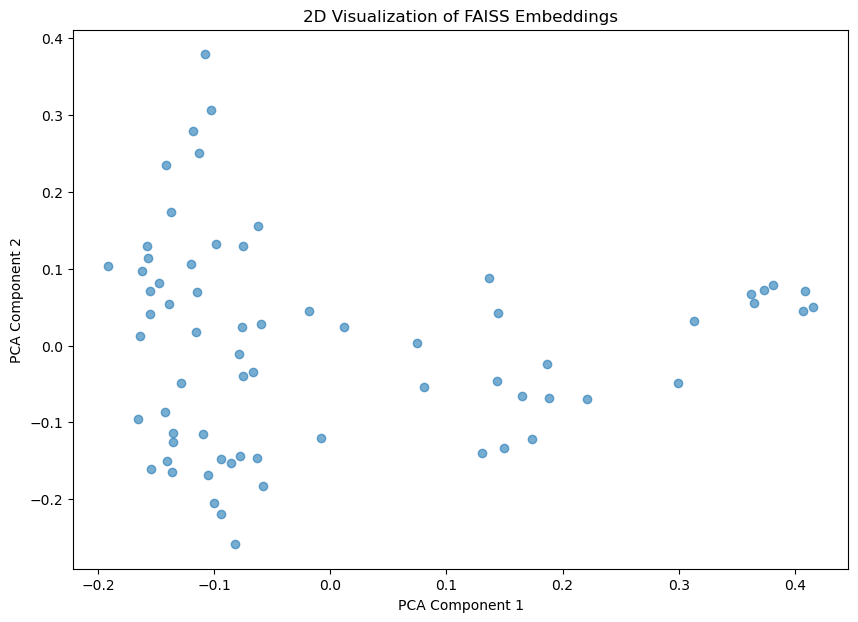

In [34]:
plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.6)
plt.title('2D Visualization of FAISS Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [35]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
reduced_vectors_tsne = tsne.fit_transform(retrieved_vectors)

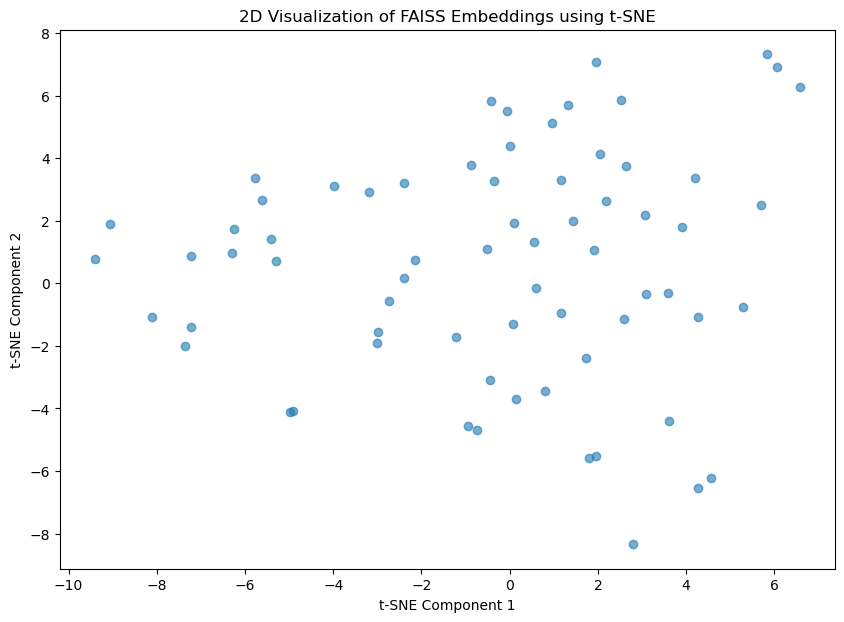

In [36]:
plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors_tsne[:, 0], reduced_vectors_tsne[:, 1], alpha=0.6)
plt.title('2D Visualization of FAISS Embeddings using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [54]:
query_text = "Scientific Discovery Agent"
query_embedding = embedding.embed_query(query_text)

In [55]:
query_embedding

[-0.012490006632871512,
 -0.005402119164694983,
 0.0069416013771656845,
 -0.020730762906682486,
 0.0028508283539972405,
 0.03853581330637349,
 -0.02559301907489764,
 0.0012234006555679122,
 -0.013360754092368605,
 -0.010163368281156488,
 0.005795697467147779,
 0.023043469604519348,
 0.005948948919436432,
 0.004433847799744416,
 -0.006760485685798169,
 -0.004642827264529522,
 0.024840693001671257,
 -0.006704758138962988,
 0.001170285002796592,
 -0.002169903520295559,
 -0.0032670457104173644,
 0.009202062743145,
 0.013618495742711081,
 -0.0036432087470305544,
 -0.0023997809315591755,
 -0.008198961312176494,
 0.02121838289961112,
 -0.03611165151486626,
 0.0026313999159728796,
 0.0020845701612314292,
 0.01969979816795766,
 -0.012016319225143578,
 -0.0067326219123805785,
 -0.02227721094609227,
 -0.00012658496675600455,
 -0.017289568961651132,
 0.0025321346701999542,
 -0.005726037335111896,
 0.013980726194123572,
 -0.012754713644491798,
 0.01871062932218985,
 0.026192094161496635,
 -0.009529

In [56]:
import numpy as np
query_vector = np.array(query_embedding).reshape(1, -1).astype('float32')

In [57]:
D, I = vectorstore.index.search(query_vector, k=6)

In [58]:
similarity_scores = D[0]
similar_documents_indices = I[0]

In [59]:
similarity_scores

array([0.30330643, 0.34452638, 0.41243327, 0.41431218, 0.42322564,
       0.42501643], dtype=float32)

In [60]:
similar_documents = [all_splits[i] for i in similar_documents_indices]

# Print the results
for doc, score in zip(similar_documents, similarity_scores):
    print(f"Document: {doc}")
    print(f"Similarity Score: {score}\n")

Document: page_content='Case Studies#
Scientific Discovery Agent#
ChemCrow (Bran et al. 2023) is a domain-specific example in which LLM is augmented with 13 expert-designed tools to accomplish tasks across organic synthesis, drug discovery, and materials design. The workflow, implemented in LangChain, reflects what was previously described in the ReAct and MRKLs and combines CoT reasoning with tools relevant to the tasks:

The LLM is provided with a list of tool names, descriptions of their utility, and details about the expected input/output.
It is then instructed to answer a user-given prompt using the tools provided when necessary. The instruction suggests the model to follow the ReAct format - Thought, Action, Action Input, Observation.' metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 22305}
Similarity Score: 0.3033064305782318

Document: page_content='They also discussed the risks, especially with illicit drugs and bioweapons. They develo

In [65]:
from langchain import LLMChain
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOpenAI

from dotenv import load_dotenv
import streamlit as st
import os
import json

In [62]:
pip install langchain_openai

  Obtaining dependency information for langchain_openai from https://files.pythonhosted.org/packages/25/e1/e8a255f391d9eeef36ff6d617c01160f3fce7c5f4ae4ce8250d661336f44/langchain_openai-0.1.17-py3-none-any.whl.metadata
  Obtaining dependency information for openai<2.0.0,>=1.32.0 from https://files.pythonhosted.org/packages/43/18/8425b246cefad230b2574018bba0c039d70750b0a270eba1c9576a1fcab2/openai-1.37.1-py3-none-any.whl.metadata
  Obtaining dependency information for tiktoken<1,>=0.7 from https://files.pythonhosted.org/packages/b1/10/c04b4ff592a5f46b28ebf4c2353f735c02ae7f0ce1b165d00748ced6467e/tiktoken-0.7.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/46.7 kB ? eta -:--:--
   ---------------------------------------- 46.7/46.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/337.0 kB ? eta -:--:--
   -------------------------- ------------- 225.3/337.0 kB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 337.0/33

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\razee\\anaconda3\\Lib\\site-packages\\~iktoken\\_tiktoken.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

